# PV Forecasting with LSTMs

In this example, we will train an LSTM model to forecast photovoltaic (PV) output.
We will demonstrate two potential applications of the SHAP toolbox in this context:

1) Forecasting with Historical PV Data:
    We will predict future PV output based solely on historical PV data (i.e., using past PV output to forecast the next time step).
    SHAP analysis will help us identify which features are most influential in making these predictions.
    This approach is useful for determining how many past time steps should be included when training the forecasting model.

2) Forecasting with Historical Data and External Factors:
    In this case, we will predict PV output not only based on historical PV records but also by incorporating external factors such as solar radiation and opacity.
    SHAP analysis will then help us understand the significance of these external features in predicting the next time steps.


## Load the Dataset

In [1]:
# Load data
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import sys

# Get the parent directory (one level up from python_based)
parent_dir = os.path.abspath(os.path.join(os.getcwd()))

# Append the "data" folder to sys.path
data_path = os.path.join(parent_dir, "data")
sys.path.append(data_path)

# Append the "functions" folder to sys.path
functions_path = os.path.join(parent_dir, "functions")
sys.path.append(functions_path)

###  Load prosumer data ###
file_P = os.path.join(data_path,'ProsumerHourly_withUTC.csv')
df_pro = pd.read_csv(file_P)
df_pro["TimeUTC"] = pd.to_datetime(df_pro["TimeUTC"])
df_pro = df_pro.loc[df_pro["TimeUTC"].dt.year.isin([2022,2023])]
df_pro = df_pro.reset_index(drop=True)
df_pro.rename(columns={'Consumption': 'Load'}, inplace=True)
df_pro.rename(columns={'TimeUTC': 'HourUTC'}, inplace=True)
df_pro = df_pro[["HourUTC","Load","PV"]]
    
###  Load weather data ###
file_P = os.path.join(data_path,'WeatherData.csv')
df_weather = pd.read_csv(file_P)
df_weather["HourUTC"] = pd.to_datetime(df_weather["HourUTC"])
df_weather = df_weather.loc[df_weather["HourUTC"].dt.year.isin([2022,2023])]
df_weather = df_weather.drop(df_weather.index[-1])

### Merge the dataframes ###
df_merged = pd.merge(df_pro, df_weather, on='HourUTC')
df_merged = df_merged.drop(['index'], axis=1)

df_merged.rename(columns={'snow_soiling_rooftop': 'snow', 
                          'clearsky_dhi': 'cs_dhi', 
                          'clearsky_dni': 'cs_dni',
                          'clearsky_ghi': 'cs_ghi', 
                          'clearsky_gti': 'cs_gti',
                          'cloud_opacity': 'opacity',
                          'dewpoint_temp': 'dew_t'}, inplace=True)

del df_pro, df_weather

### Pre-Process the Dataset for Training and Testing

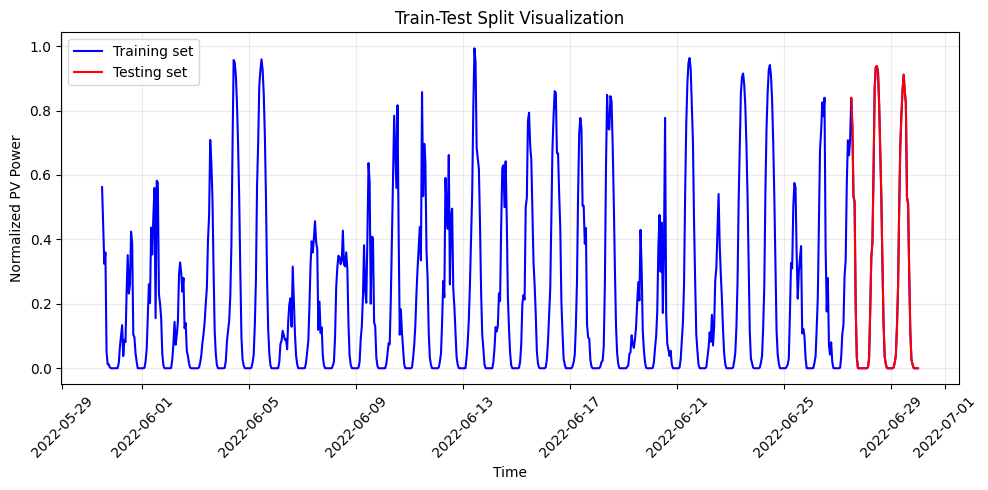

Size training data: (695, 36, 1), Size validation set: 0, Size testing data: (25, 36, 1)
Size training labels: (695, 1), Size validation set: 0, Size testing labels: (25, 1)


In [2]:
from forecasting_support import TimeSeriesDataPreparer

look_back = 36
look_ahead = 1

prep = TimeSeriesDataPreparer(
    df=df_merged, 
    target='PV', 
    exog=['PV'], 
    look_back=look_back, 
    look_ahead=look_ahead
)

# Generate datasets
X_train, y_train, X_test, y_test = prep.prepare_data(
    t_s="2022-06-01 00:00:00", 
    t_e="2022-06-29 23:00:00",
    test_ts="2022-06-29 00:00:00", 
    test_te="2022-06-30 00:00:00",
    visualize = True
)


print(f'Size training data: {X_train.shape}, Size validation set: {0}, Size testing data: {X_test.shape}')
print(f'Size training labels: {y_train.shape}, Size validation set: {0}, Size testing labels: {y_test.shape}')

### 1) Determining the Optimal Number of Previous Time Steps for Our Forecasting Model

In the first case study, we will forecast the next PV output based solely on historical PV data.
The goal is to use SHAP analysis to determine how many past time steps should be included in our forecasting model.

The process begins by initializing the LSTM model and training it on the dataset we've prepared.


Epoch 1/25, Loss: 0.1116
Epoch 2/25, Loss: 0.0734
Epoch 3/25, Loss: 0.0688
Epoch 4/25, Loss: 0.0582
Epoch 5/25, Loss: 0.0320
Epoch 6/25, Loss: 0.0154
Epoch 7/25, Loss: 0.0119
Epoch 8/25, Loss: 0.0113
Epoch 9/25, Loss: 0.0114
Epoch 10/25, Loss: 0.0109
Epoch 11/25, Loss: 0.0112
Epoch 12/25, Loss: 0.0107
Epoch 13/25, Loss: 0.0103
Epoch 14/25, Loss: 0.0110
Epoch 15/25, Loss: 0.0107
Epoch 16/25, Loss: 0.0101
Epoch 17/25, Loss: 0.0098
Epoch 18/25, Loss: 0.0099
Epoch 19/25, Loss: 0.0094
Epoch 20/25, Loss: 0.0094
Epoch 21/25, Loss: 0.0098
Epoch 22/25, Loss: 0.0094
Epoch 23/25, Loss: 0.0092
Epoch 24/25, Loss: 0.0096
Epoch 25/25, Loss: 0.0089


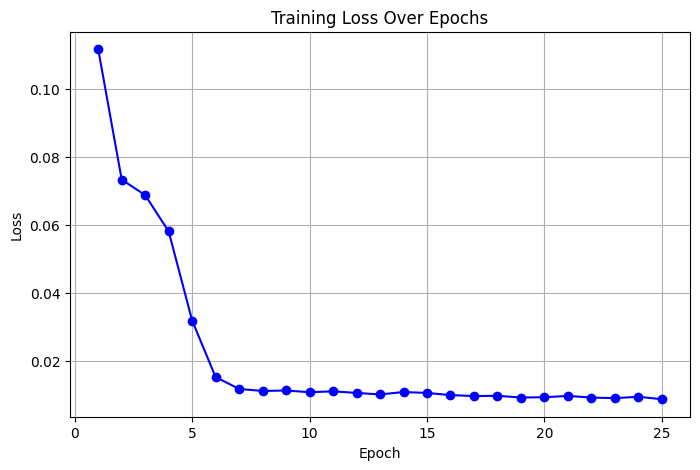

In [3]:
from forecasting_support import LSTMTimeSeries, LSTMTrainer

model = LSTMTimeSeries(input_size=X_train.shape[2], hidden_size=32, output_size=look_ahead, num_layers=2, dropout=0.002)
trainer = LSTMTrainer(model)
trainer.train(X_train, y_train, num_epochs=25, batch_size=32)
y_pred = trainer.evaluate(X_test)
trainer.plot_losses()

In [4]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.004225478318802696
Mean Absolute Error (MAE): 0.04263354003260737
Root Mean Squared Error (RMSE): 0.06500367927127429
R-squared (R2) Score: 0.9634962305314225


We compare the performance of our prediction with the ground truth. 

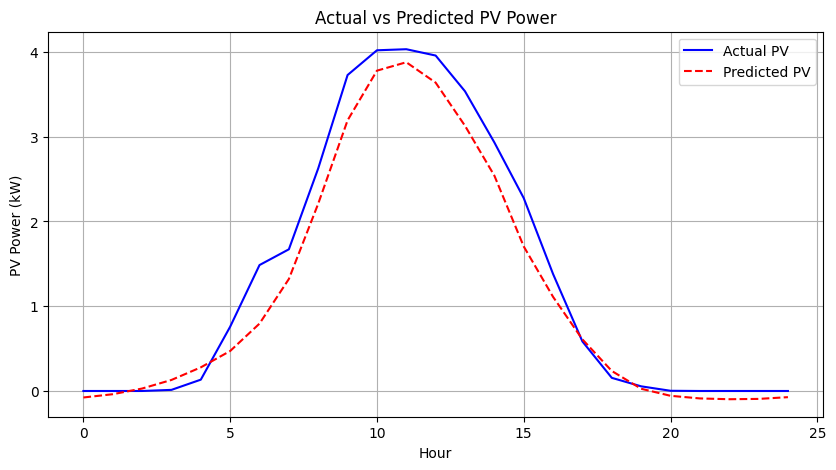

In [5]:
prep.plot_predictions(y_pred, y_test)

# Do SHAP analysis

Next, we import the GradientExplainer from the SHAP toolbox to explain the prediction made by our LSTM. More specifically, we are interested in which features were important to make the predictions made by our forecasting tool. 

In [6]:
import shap 
import torch
torch.set_grad_enabled(True)
shap.plots.initjs()

# we use no exogeneous variables, but we predict only using PV output
exog = ['PV']

# explainability model learning data
learning_samples = 200
learning_set = torch.tensor(X_train, dtype=torch.float32)[:learning_samples]

# data to explain
explaining_samples = 96
features = torch.tensor(X_train)[-explaining_samples:]
labels = torch.tensor(y_train)[-explaining_samples:]
feature_names = np.array([f"{var}_t{i+1}" for i in range(look_back) for var in exog])


# Load SHAP GradientExplainer
explainer = shap.GradientExplainer(model, learning_set) 

# Compute SHAP values for the test set 
shap_explainer = explainer(features) # explainer.shap_values(features)

# Print shapes for debugging
print(f"shap values shape: {shap_explainer.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")

shap_values = shap_explainer.values.reshape(features.shape[0], look_back*len(exog), look_ahead) # reshape from [num_samp_expl, look_back, len(exog), look ahead]
features = features.reshape(features.shape[0], look_back*len(exog)).unsqueeze(-1)
labels = labels.unsqueeze(1).expand(-1, look_back*len(exog), -1)

print(f"shap values shape after reshaping: {shap_values.shape}")
print(f"features shape after reshaping: {features.shape}")
print(f"labels shape after reshaping: {labels.shape}")

# Stack features and labels_expanded along the last dimension and remove the first channel
data = torch.cat((features, labels), dim=-1)[..., 1:]

# Print final shapes
print(f"data shape: {data.shape}")
print(f"shap values shape: {shap_values.shape}")

# Enable JS visualization
shap.initjs()
    

c:\Users\bagir\AppData\Local\anaconda3\envs\shap\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


shap values shape: (96, 36, 1, 1)
features shape: torch.Size([96, 36, 1])
labels shape: torch.Size([96, 1])
shap values shape after reshaping: (96, 36, 1)
features shape after reshaping: torch.Size([96, 36, 1])
labels shape after reshaping: torch.Size([96, 36, 1])
data shape: torch.Size([96, 36, 1])
shap values shape: (96, 36, 1)


# Explain a single prediction

The expected value is the PV output the model predicts. We can use either the force plot or the waterfall plot. 

In [7]:
# This is a force plot for a single prediction
shap.initjs()
expected_value = shap_values[:,:,0].mean()
force_plot = shap.force_plot(expected_value, shap_values[12,:,0], feature_names)
plt.show()

# Save as an HTML file
shap.save_html('figures/forecasting/force_endogenous_local.html', force_plot)

# Global Importance of Features

We can plot global importance using a bar plot, a beeswarm plot or a force plot over all samples. 

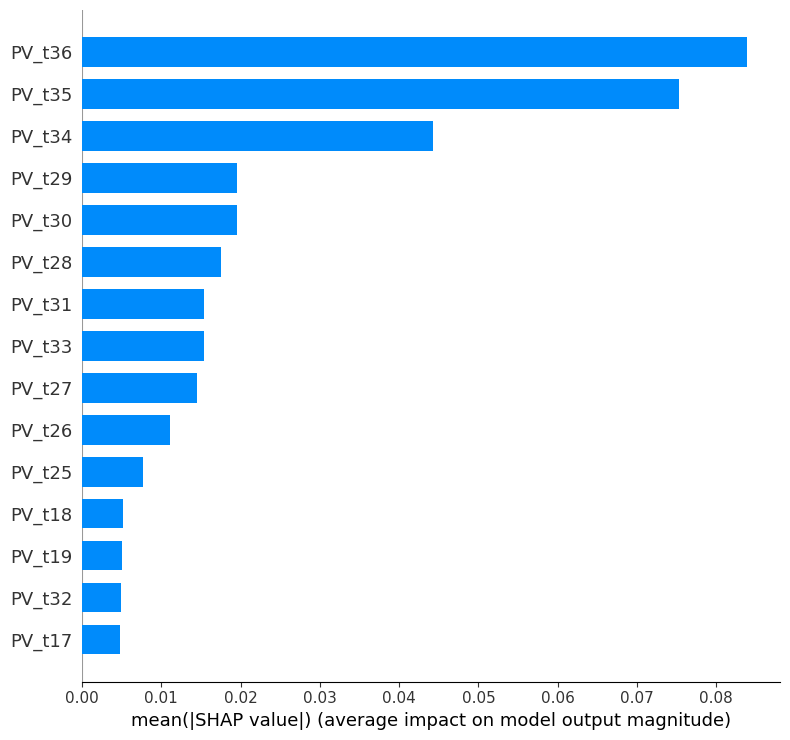

In [8]:
# Summary Plot
fig=plt.gcf()
if look_ahead == 1: # just predicting the next value i.e. one class
    summary_plot = shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, plot_type="bar", max_display = 15) # , plot_type="bar"
elif look_ahead > 1: # predicting multiple future time steps i.e. multi-class/multi-output prediction
    print("Can't plot a beaswarm for multiple classes. Taking the first and last prediction for comparison...")
    summary_plot = shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, plot_type="bar", max_display = 15) # plot the first predicted class
    #shap.summary_plot(shap_values[:,:,-1], data[:,:,-1], feature_names) # plot the last predicted class
    
fig.savefig('figures/forecasting/bar_endogenous_global.png', bbox_inches='tight', pad_inches=0.1)

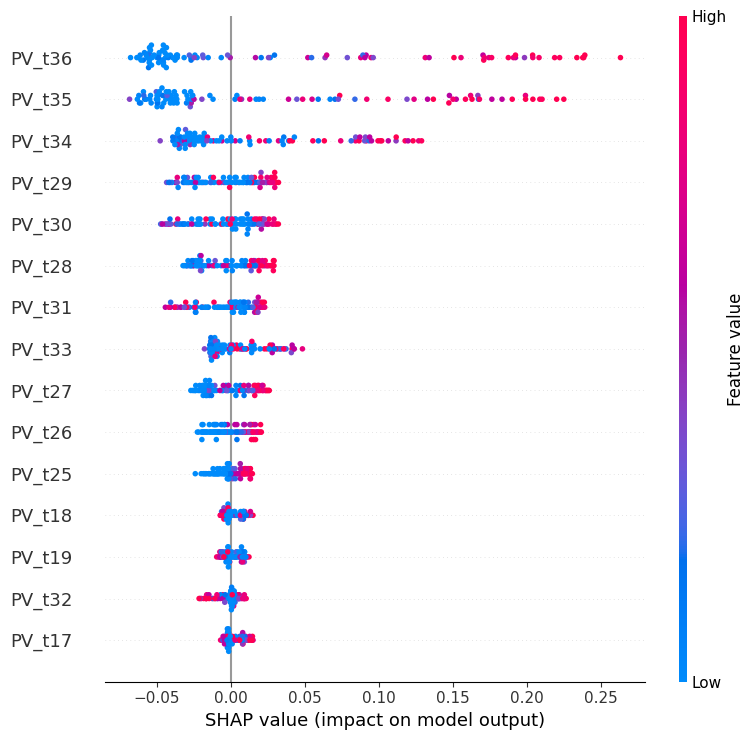

In [9]:
# Summary Plot
fig=plt.gcf()
if look_ahead == 1: # just predicting the next value i.e. one class
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # , plot_type="bar"
elif look_ahead > 1: # predicting multiple future time steps i.e. multi-class/multi-output prediction
    print("Can't plot a beaswarm for multiple classes. Taking the first and last prediction for comparison...")
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # plot the first predicted class
    #shap.summary_plot(shap_values[:,:,-1], data[:,:,-1], feature_names) # plot the last predicted class
    
fig.savefig('figures/forecasting/beeswarm_endogenous_global.png', bbox_inches='tight', pad_inches=0.1)

In [10]:
# the force plot shows the explanations for all predictions!
expected_value = shap_values[:,:,0].mean()
force_plot = shap.force_plot(expected_value, shap_values[:,:,0], feature_names)

# Save as an HTML file
shap.save_html('figures/forecasting/force_endogenous_global.html', force_plot)

### Take More/Less Endogeneous Features and Retrain!

Based on this analysis, we see that final time steps are the most important to predict the next one. Therefore, we retrain our model, using fewer endogeneous variables, and test the performance again.

In [11]:
from forecasting_support import TimeSeriesDataPreparer

look_back = 24
look_ahead = 1

prep = TimeSeriesDataPreparer(
    df=df_merged, 
    target='PV', 
    exog=['PV'], 
    look_back=look_back, 
    look_ahead=look_ahead
)

# Generate datasets
X_train, y_train, X_test, y_test = prep.prepare_data(
    t_s="2022-06-01 00:00:00", 
    t_e="2022-06-29 23:00:00",
    test_ts="2022-06-29 00:00:00", 
    test_te="2022-06-30 00:00:00",
    visualize = False
)


print(f'Size training data: {X_train.shape}, Size validation set: {0}, Size testing data: {X_test.shape}, Size data: {0}')
print(f'Size training labels: {y_train.shape}, Size validation set: {0}, Size testing labels: {y_test.shape}, Size data: {0}')

Size training data: (695, 24, 1), Size validation set: 0, Size testing data: (25, 24, 1), Size data: 0
Size training labels: (695, 1), Size validation set: 0, Size testing labels: (25, 1), Size data: 0


Epoch 1/25, Loss: 0.0768
Epoch 2/25, Loss: 0.0700
Epoch 3/25, Loss: 0.0552
Epoch 4/25, Loss: 0.0219
Epoch 5/25, Loss: 0.0125
Epoch 6/25, Loss: 0.0120
Epoch 7/25, Loss: 0.0122
Epoch 8/25, Loss: 0.0113
Epoch 9/25, Loss: 0.0106
Epoch 10/25, Loss: 0.0105
Epoch 11/25, Loss: 0.0104
Epoch 12/25, Loss: 0.0097
Epoch 13/25, Loss: 0.0095
Epoch 14/25, Loss: 0.0092
Epoch 15/25, Loss: 0.0095
Epoch 16/25, Loss: 0.0090
Epoch 17/25, Loss: 0.0091
Epoch 18/25, Loss: 0.0086
Epoch 19/25, Loss: 0.0086
Epoch 20/25, Loss: 0.0085
Epoch 21/25, Loss: 0.0084
Epoch 22/25, Loss: 0.0085
Epoch 23/25, Loss: 0.0080
Epoch 24/25, Loss: 0.0079
Epoch 25/25, Loss: 0.0079


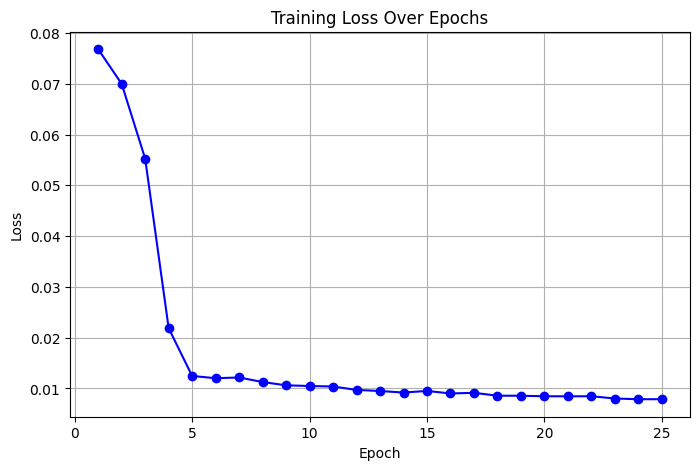

In [12]:
from forecasting_support import LSTMTimeSeries, LSTMTrainer

model = LSTMTimeSeries(input_size=X_train.shape[2], hidden_size=32, output_size=look_ahead, num_layers=2, dropout=0.002)
trainer = LSTMTrainer(model)
trainer.train(X_train, y_train, num_epochs=25, batch_size=32)
y_pred = trainer.evaluate(X_test)
trainer.plot_losses()

In [13]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse_n = mean_squared_error(y_test, y_pred)
mae_n = mean_absolute_error(y_test, y_pred)
rmse_n = np.sqrt(mse)
r2_n = r2_score(y_test, y_pred)

# Print results
print(f"This is the new MSE: {mse_n}")
print(f"Mean Squared Error (MSE) improvement [%]: {(mse_n/mse)*100 - 100}")
print(f"New mean Absolute Error (MAE): {(mae_n/mae)*100 - 100}")
print(f"New Root Mean Squared Error (RMSE): {(rmse_n/rmse)*100 - 100}")
print(f"New R-squared (R2) Score: {(r2_n/r2)*100 - 100}")

This is the new MSE: 0.003747324061718772
Mean Squared Error (MSE) improvement [%]: -11.315979423115593
New mean Absolute Error (MAE): -12.958418766991826
New Root Mean Squared Error (RMSE): 0.0
New R-squared (R2) Score: 0.42872601997079585


In [14]:
import shap 
import torch
torch.set_grad_enabled(True)
shap.plots.initjs()

# we use no exogeneous variables, but we predict only using PV output
exog = ['PV']

# explainability model learning data
learning_samples = 200
learning_set = torch.tensor(X_train, dtype=torch.float32)[:learning_samples]

# data to explain
explaining_samples = 96
features = torch.tensor(X_train)[-explaining_samples:]
labels = torch.tensor(y_train)[-explaining_samples:]
feature_names = np.array([f"{var}_t{i+1}" for i in range(look_back) for var in exog])

# Load SHAP GradientExplainer
explainer = shap.GradientExplainer(model, learning_set) 

# Compute SHAP values for the test set 
shap_explainer = explainer(features) # explainer.shap_values(features)

# Print shapes for debugging
print(f"shap values shape: {shap_explainer.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")

shap_values = shap_explainer.values.reshape(features.shape[0], look_back*len(exog), look_ahead) # reshape from [num_samp_expl, look_back, len(exog), look ahead]
features = features.reshape(features.shape[0], look_back*len(exog)).unsqueeze(-1)
labels = labels.unsqueeze(1).expand(-1, look_back*len(exog), -1)

print(f"shap values shape after reshaping: {shap_values.shape}")
print(f"features shape after reshaping: {features.shape}")
print(f"labels shape after reshaping: {labels.shape}")

# Stack features and labels_expanded along the last dimension and remove the first channel
data = torch.cat((features, labels), dim=-1)[..., 1:]

# Print final shapes
print(f"data shape: {data.shape}")
print(f"shap values shape: {shap_values.shape}")

# Enable JS visualization
shap.initjs()
    

shap values shape: (96, 24, 1, 1)
features shape: torch.Size([96, 24, 1])
labels shape: torch.Size([96, 1])
shap values shape after reshaping: (96, 24, 1)
features shape after reshaping: torch.Size([96, 24, 1])
labels shape after reshaping: torch.Size([96, 24, 1])
data shape: torch.Size([96, 24, 1])
shap values shape: (96, 24, 1)


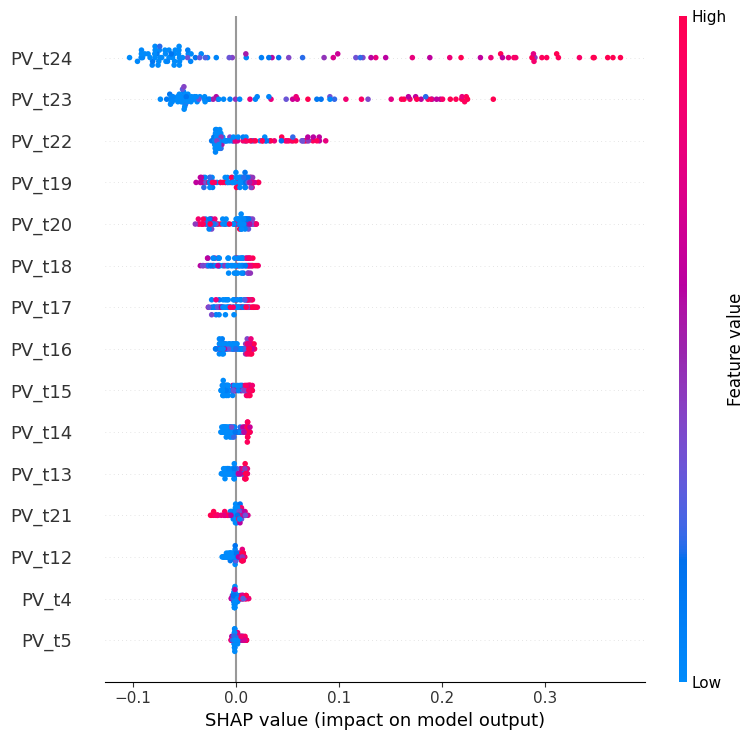

In [15]:
# Summary Plot
fig=plt.gcf()
if look_ahead == 1: # just predicting the next value i.e. one class
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # , plot_type="bar"
elif look_ahead > 1: # predicting multiple future time steps i.e. multi-class/multi-output prediction
    print("Can't plot a beaswarm for multiple classes. Taking the first and last prediction for comparison...")
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # plot the first predicted class
    #shap.summary_plot(shap_values[:,:,-1], data[:,:,-1], feature_names) # plot the last predicted class
    
fig.savefig('figures/forecasting/beeswarm_endogenous_global_reduced.png', bbox_inches='tight', pad_inches=0.1)

# 2) Determine Which Exogeneous Features are of Importance

Next, we will use the SHAP analysis to determine which external factors are important to include in our prediction. First, we will determine correlation between variables to determine which variables to consider as exogeneous variables. Next, we can use the SHAP toolbox to perform feature importance analysis to analyze whether the features were actually of importance on our model prediction. 



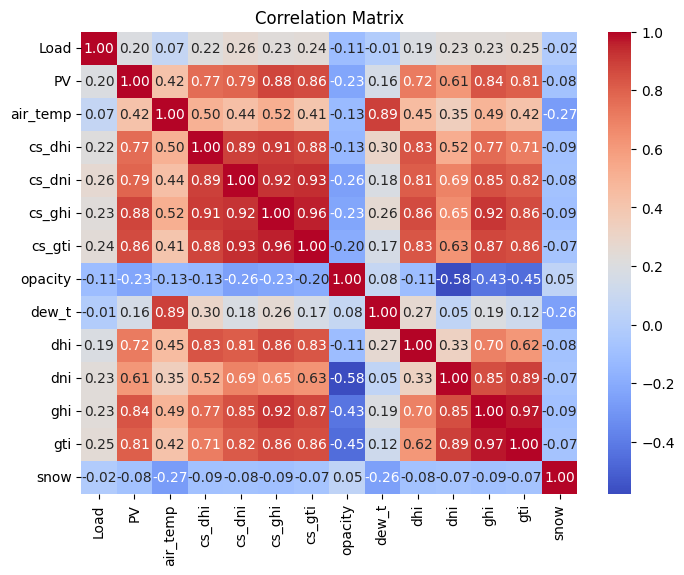

Load        0.197916
PV          1.000000
air_temp    0.415301
cs_dhi      0.765300
cs_dni      0.789711
cs_ghi      0.877799
cs_gti      0.858331
opacity    -0.229459
dew_t       0.157533
dhi         0.715517
dni         0.614826
ghi         0.835125
gti         0.806784
snow       -0.079596
Name: PV, dtype: float64


In [16]:
""""
df_pro = df_pro[["HourUTC","Load","PV"]]
df_merged.rename(columns={'snow_soiling_rooftop': 'snow', 
                          'clearsky_dhi': 'cs_dhi', # diffuse horizontal irradiance
                          'clearsky_dni': 'cs_dni', # direct normal irradiance
                          'clearsky_ghi': 'cs_ghi', # global horizontal irradiance
                          'clearsky_gti': 'cs_gti', # global tilted irradiance
                          'cloud_opacity': 'opacity', # clouds 
                          'dewpoint_temp': 'dew_t'}, inplace=True)
"""

import seaborn as sns
data_corr = df_merged.drop(['HourUTC'], axis=1)

## Shift dataframe by 24 hours
data_corr = data_corr.shift(24, axis=0)
data_corr['PV'] = df_merged['PV']
data_corr = data_corr.iloc[24:]
clean_data_corr = data_corr.dropna()
correlation_matrix = data_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print(correlation_matrix['PV'])

Include the external features which are highly correlated with PV output. Next, recreate the datasets to train our LSTM. 

In [17]:
from forecasting_support import TimeSeriesDataPreparer

look_back = 24
look_ahead = 1
exog = ['PV', 'cs_ghi', 'cs_gti', 'dew_t']

prep = TimeSeriesDataPreparer(
    df=df_merged, 
    target='PV', 
    exog= exog, 
    look_back=look_back, 
    look_ahead=look_ahead
)

# Generate datasets
X_train, y_train, X_test, y_test = prep.prepare_data(
    t_s="2022-06-01 00:00:00", 
    t_e="2022-06-29 23:00:00",
    test_ts="2022-06-29 00:00:00", 
    test_te="2022-06-30 00:00:00",
    visualize = False
)


print(f'Size training data: {X_train.shape}, Size validation set: {0}, Size testing data: {X_test.shape}')
print(f'Size training labels: {y_train.shape}, Size validation set: {0}, Size testing labels: {y_test.shape}')

Size training data: (695, 24, 4), Size validation set: 0, Size testing data: (25, 24, 4)
Size training labels: (695, 1), Size validation set: 0, Size testing labels: (25, 1)


### Reinitialize an LSTM model. 

Epoch 1/25, Loss: 0.0983
Epoch 2/25, Loss: 0.0647
Epoch 3/25, Loss: 0.0435
Epoch 4/25, Loss: 0.0205
Epoch 5/25, Loss: 0.0170
Epoch 6/25, Loss: 0.0148
Epoch 7/25, Loss: 0.0138
Epoch 8/25, Loss: 0.0124
Epoch 9/25, Loss: 0.0119
Epoch 10/25, Loss: 0.0113
Epoch 11/25, Loss: 0.0112
Epoch 12/25, Loss: 0.0110
Epoch 13/25, Loss: 0.0100
Epoch 14/25, Loss: 0.0102
Epoch 15/25, Loss: 0.0097
Epoch 16/25, Loss: 0.0091
Epoch 17/25, Loss: 0.0099
Epoch 18/25, Loss: 0.0085
Epoch 19/25, Loss: 0.0087
Epoch 20/25, Loss: 0.0086
Epoch 21/25, Loss: 0.0085
Epoch 22/25, Loss: 0.0088
Epoch 23/25, Loss: 0.0081
Epoch 24/25, Loss: 0.0083
Epoch 25/25, Loss: 0.0084


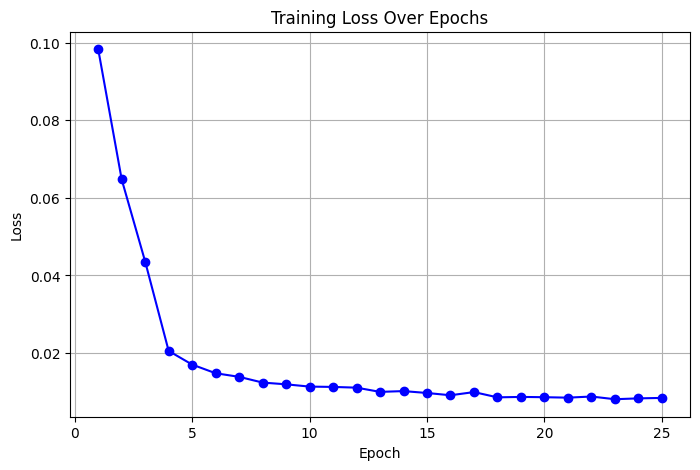

In [18]:
from forecasting_support import LSTMTimeSeries, LSTMTrainer

model = LSTMTimeSeries(input_size=X_train.shape[2], hidden_size=32, output_size=look_ahead, num_layers=2, dropout=0.002)
trainer = LSTMTrainer(model)
trainer.train(X_train, y_train, num_epochs=25, batch_size=32)
y_pred = trainer.evaluate(X_test)
trainer.plot_losses()

### Evaluate the performance. 

In [19]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.004378588145015347
Mean Absolute Error (MAE): 0.044982604520783245
Root Mean Squared Error (RMSE): 0.06617090104430608
R-squared (R2) Score: 0.9621735197333172


### Plot the prediction against the ground truth. 

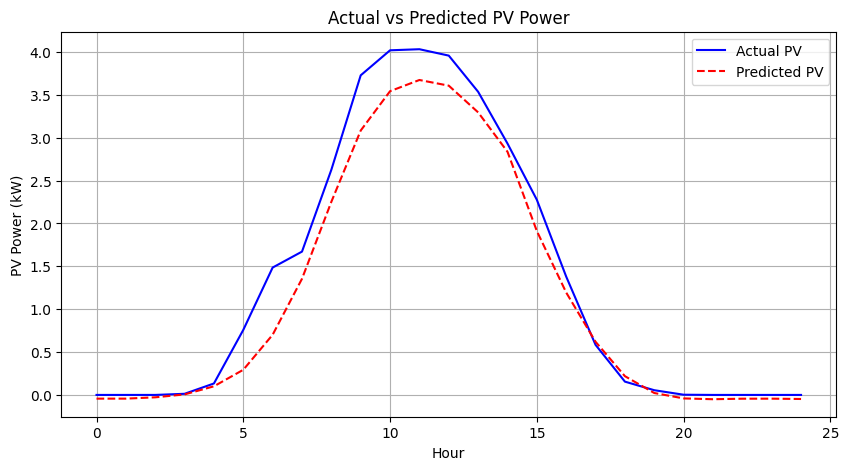

In [20]:
prep.plot_predictions(y_pred, y_test)

# Do SHAP analysis

Next, we import the GradientExplainer from the SHAP toolbox to explain the prediction made by our LSTM. More specifically, we are interested in which features were important to make the predictions made by our forecasting tool. This time, we have included external features, so we can analyze the importance of including them in making our prediction!

In [21]:
import shap 
torch.set_grad_enabled(True)

# explainability model learning data
learning_samples = 200
learning_set = torch.tensor(X_train, dtype = torch.float32)[:learning_samples]

# data to explain
explaining_samples = 96
features = torch.tensor(X_train)[:explaining_samples]
labels = torch.tensor(y_train)[:explaining_samples]
feature_names = np.array([f"{var}_t{i+1}" for i in range(look_back) for var in exog])

# Load SHAP gradient explainer
explainer = shap.GradientExplainer(model, learning_set) 

# Compute SHAP values for the test set 
shap_values = explainer.shap_values(features)

# Print shapes for debugging
print(f"shap values shape: {shap_values.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")

shap_values = shap_values.reshape(features.shape[0], look_back*len(exog), look_ahead) # reshape from [features.shape[0], look_back, len(exog), look ahead]
features = features.reshape(features.shape[0], look_back*len(exog)).unsqueeze(-1)
labels = labels.unsqueeze(1).expand(-1, look_back*len(exog), -1)

print(f"shap values shape after reshaping: {shap_values.shape}")
print(f"features shape after reshaping: {features.shape}")
print(f"labels shape after reshaping: {labels.shape}")

# Stack features and labels_expanded along the last dimension and remove the first channel
data = torch.cat((features, labels), dim=-1)[..., 1:]

# Print final shapes
print(f"final data shape: {data.shape}")
print(f"final shap values shape: {shap_values.shape}")

# Enable JS visualization
shap.initjs()

    

shap values shape: (96, 24, 4, 1)
features shape: torch.Size([96, 24, 4])
labels shape: torch.Size([96, 1])
shap values shape after reshaping: (96, 96, 1)
features shape after reshaping: torch.Size([96, 96, 1])
labels shape after reshaping: torch.Size([96, 96, 1])
final data shape: torch.Size([96, 96, 1])
final shap values shape: (96, 96, 1)


# Explain a single prediction

The expected value is the normalized PV output the model predicts. We can use either the force plot or the waterfall plot. 

In [22]:
# This is a force plot for a single prediction
expected_value = shap_values[:,:,0].mean()
force_plot = shap.force_plot(expected_value, shap_values[12,:,0], feature_names)

# Save as an HTML file
shap.save_html('figures/forecasting/force_exogeneous_local.html', force_plot)

# Interaction plots

You can choose a feature to analyze, and SHAP will automatically determine which feature interacts most strongly with that main feature. You can also explicitely select a feature to analyze.

<Figure size 640x480 with 0 Axes>

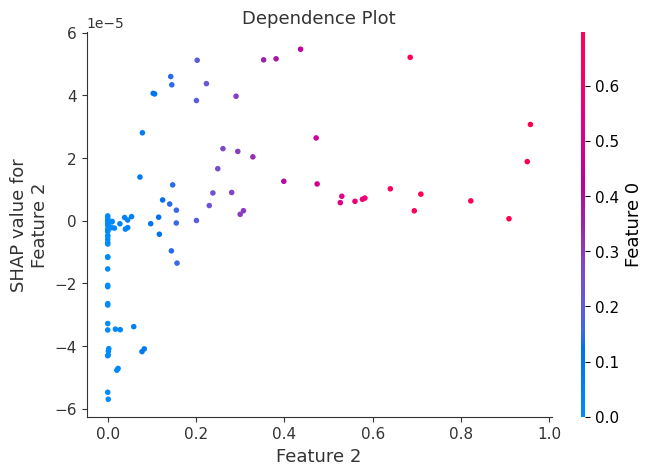

In [23]:
# Convert tensors to NumPy arrays if they are tensors
shap_values_np = shap_values[:,:,0] 
features_np = data[:,:,0].cpu().detach().numpy()  

fig=plt.gcf()
# Now pass them to the dependence plot function
shap.dependence_plot(ind=2,  
                    shap_values=shap_values_np,  
                    features=features_np,  
                    #display_features=features,  # Optional: Display the raw features on the plot
                    #interaction_index=0
                    title=f"Dependence Plot")

fig.savefig('figures/forecasting/dependence_exogeneous.png', bbox_inches='tight', pad_inches=0.1)

# Global Importance of Features

We can plot global importance using a bar plot, a beeswarm plot or a force plot over all samples. 

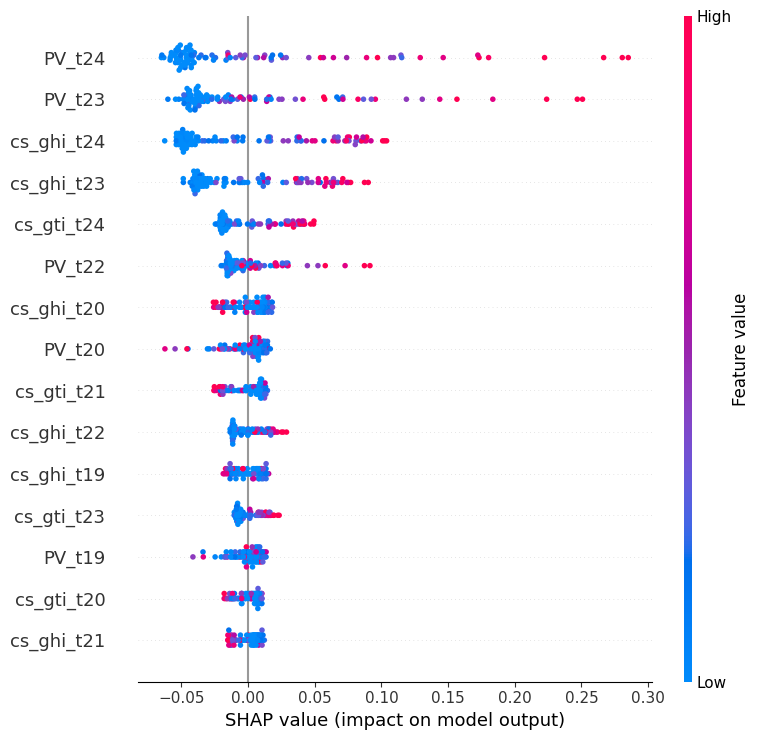

In [24]:
# Summary Plot
fig=plt.gcf()
if look_ahead == 1: # just predicting the next value i.e. one class
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # , plot_type="bar"
elif look_ahead > 1: # predicting multiple future time steps i.e. multi-class/multi-output prediction
    print("Can't plot a beaswarm for multiple classes. Taking the first and last prediction for comparison...")
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # plot the first predicted class
    #shap.summary_plot(shap_values[:,:,-1], data[:,:,-1], feature_names) # plot the last predicted class
    
fig.savefig('figures/forecasting/beeswarm_exogeneous_global.png', bbox_inches='tight', pad_inches=0.1)

## Perform Feature Selection

We see that dew_t doesn't really influence the prediction. Maybe we should try again with opacity instead of temperature.

In [25]:
from forecasting_support import TimeSeriesDataPreparer

look_back = 24
look_ahead = 1
exog = ['PV', 'cs_ghi', 'cs_gti', 'opacity']

prep = TimeSeriesDataPreparer(
    df=df_merged, 
    target='PV', 
    exog= exog, 
    look_back=look_back, 
    look_ahead=look_ahead
)

# Generate datasets
X_train, y_train, X_test, y_test = prep.prepare_data(
    t_s="2022-06-01 00:00:00", 
    t_e="2022-06-29 23:00:00",
    test_ts="2022-06-29 00:00:00", 
    test_te="2022-06-30 00:00:00",
    visualize = False
)


print(f'Size training data: {X_train.shape}, Size validation set: {0}, Size testing data: {X_test.shape}')
print(f'Size training labels: {y_train.shape}, Size validation set: {0}, Size testing labels: {y_test.shape}')

Size training data: (695, 24, 4), Size validation set: 0, Size testing data: (25, 24, 4)
Size training labels: (695, 1), Size validation set: 0, Size testing labels: (25, 1)


Epoch 1/25, Loss: 0.1068
Epoch 2/25, Loss: 0.0676
Epoch 3/25, Loss: 0.0545
Epoch 4/25, Loss: 0.0298
Epoch 5/25, Loss: 0.0152
Epoch 6/25, Loss: 0.0127
Epoch 7/25, Loss: 0.0112
Epoch 8/25, Loss: 0.0101
Epoch 9/25, Loss: 0.0100
Epoch 10/25, Loss: 0.0101
Epoch 11/25, Loss: 0.0094
Epoch 12/25, Loss: 0.0090
Epoch 13/25, Loss: 0.0093
Epoch 14/25, Loss: 0.0093
Epoch 15/25, Loss: 0.0080
Epoch 16/25, Loss: 0.0081
Epoch 17/25, Loss: 0.0082
Epoch 18/25, Loss: 0.0077
Epoch 19/25, Loss: 0.0076
Epoch 20/25, Loss: 0.0077
Epoch 21/25, Loss: 0.0073
Epoch 22/25, Loss: 0.0072
Epoch 23/25, Loss: 0.0069
Epoch 24/25, Loss: 0.0069
Epoch 25/25, Loss: 0.0068


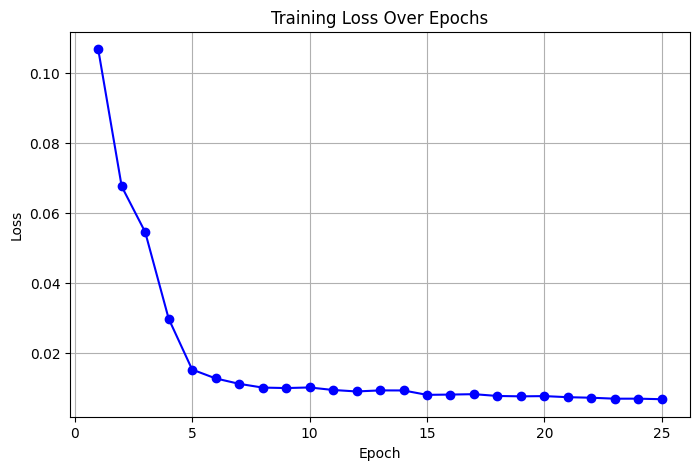

In [26]:
from forecasting_support import LSTMTimeSeries, LSTMTrainer

model = LSTMTimeSeries(input_size=X_train.shape[2], hidden_size=32, output_size=look_ahead, num_layers=2, dropout=0.002)
trainer = LSTMTrainer(model)
trainer.train(X_train, y_train, num_epochs=25, batch_size=32)
y_pred = trainer.evaluate(X_test)
trainer.plot_losses()

In [27]:
## Metrics to evaluate the performance of your model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute metrics
mse_n = mean_squared_error(y_test, y_pred)
mae_n = mean_absolute_error(y_test, y_pred)
rmse_n = np.sqrt(mse)
r2_n = r2_score(y_test, y_pred)

# Print results
print(mse_n)
print(f"Mean Squared Error (MSE) improvement [%]: {(mse_n/mse)*100 - 100}")
print(f"New mean Absolute Error (MAE): {(mae_n/mae)*100 - 100}")
print(f"New Root Mean Squared Error (RMSE): {(rmse_n/rmse)*100 - 100}")
print(f"New R-squared (R2) Score: {(r2_n/r2)*100 - 100}")

0.0019386496173638282
Mean Squared Error (MSE) improvement [%]: -55.7243213301343
New mean Absolute Error (MAE): -20.43070949284521
New Root Mean Squared Error (RMSE): 0.0
New R-squared (R2) Score: 2.1907222532510104


In [28]:
import shap 
torch.set_grad_enabled(True)

# explainability model learning data
learning_samples = 200
learning_set = torch.tensor(X_train, dtype = torch.float32)[:learning_samples]

# data to explain
explaining_samples = 96
features = torch.tensor(X_train)[:explaining_samples]
labels = torch.tensor(y_train)[:explaining_samples]
feature_names = np.array([f"{var}_t{i+1}" for i in range(look_back) for var in exog])

# Load SHAP gradient explainer
explainer = shap.GradientExplainer(model, learning_set) 

# Compute SHAP values for the test set 
shap_values = explainer.shap_values(features)

# Print shapes for debugging
print(f"shap values shape: {shap_values.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")

shap_values = shap_values.reshape(features.shape[0], look_back*len(exog), look_ahead) # reshape from [features.shape[0], look_back, len(exog), look ahead]
features = features.reshape(features.shape[0], look_back*len(exog)).unsqueeze(-1)
labels = labels.unsqueeze(1).expand(-1, look_back*len(exog), -1)

print(f"shap values shape after reshaping: {shap_values.shape}")
print(f"features shape after reshaping: {features.shape}")
print(f"labels shape after reshaping: {labels.shape}")

# Stack features and labels_expanded along the last dimension and remove the first channel
data = torch.cat((features, labels), dim=-1)[..., 1:]

# Print final shapes
print(f"final data shape: {data.shape}")
print(f"final shap values shape: {shap_values.shape}")

# Enable JS visualization
shap.initjs()

    

shap values shape: (96, 24, 4, 1)
features shape: torch.Size([96, 24, 4])
labels shape: torch.Size([96, 1])
shap values shape after reshaping: (96, 96, 1)
features shape after reshaping: torch.Size([96, 96, 1])
labels shape after reshaping: torch.Size([96, 96, 1])
final data shape: torch.Size([96, 96, 1])
final shap values shape: (96, 96, 1)


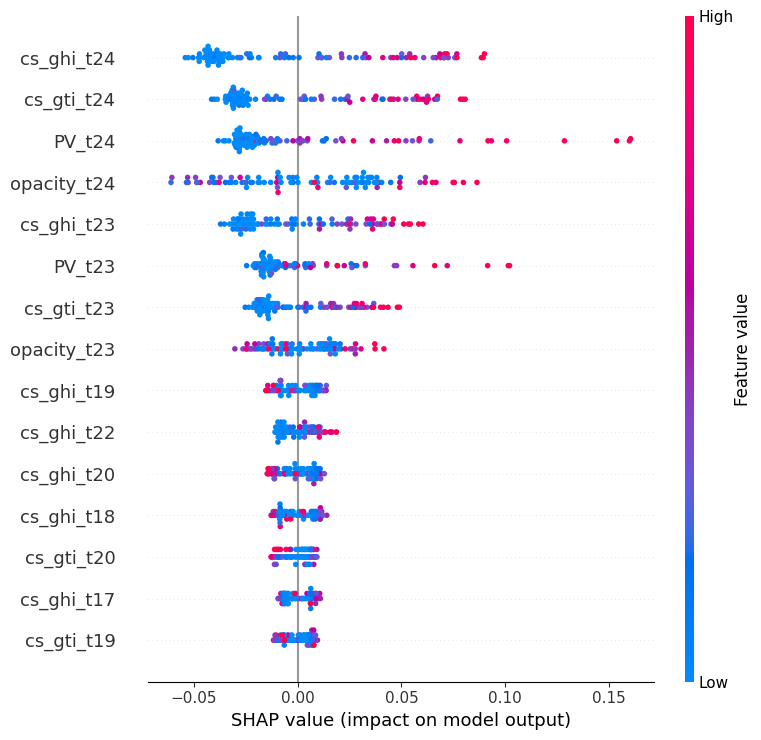

In [29]:
# Summary Plot
fig=plt.gcf()
if look_ahead == 1: # just predicting the next value i.e. one class
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # , plot_type="bar"
elif look_ahead > 1: # predicting multiple future time steps i.e. multi-class/multi-output prediction
    print("Can't plot a beaswarm for multiple classes. Taking the first and last prediction for comparison...")
    shap.summary_plot(shap_values[:,:,0], data[:,:,0], feature_names, max_display = 15) # plot the first predicted class
    #shap.summary_plot(shap_values[:,:,-1], data[:,:,-1], feature_names) # plot the last predicted class
    
fig.savefig('figures/forecasting/beeswarm_exogeneous_global_improved.png', bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>

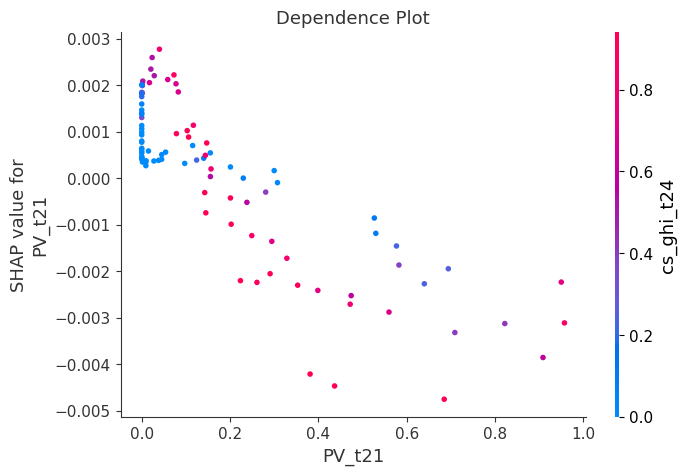

<Figure size 640x480 with 0 Axes>

In [30]:
# Convert tensors to NumPy arrays if they are tensors
shap_values_np = shap_values[:,:,0] 
features_np = features[:,:,0].cpu().detach().numpy()  

fig=plt.gcf()
# Now pass them to the dependence plot function
shap.dependence_plot(ind="PV_t21",  
                    shap_values=shap_values_np,  
                    features=features_np,  
                    display_features=features_np,  # Optional: Display the raw features on the plot
                    feature_names = feature_names,
                    interaction_index="cs_ghi_t24",
                    title=f"Dependence Plot")

plt.draw()  # Forces the plot to update
plt.pause(1)  # Small pause to allow rendering
#fig.savefig('figures/forecasting/dependence_exogeneous_try.png', bbox_inches='tight', pad_inches=0.1)